In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

import itertools
import shutil
import random
import glob
from glob import glob
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train')
data_dir_test = pathlib.Path('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Test') 

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("No.of Images in Train Dataset:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("No.of Images in Test Dataset:",image_count_test)

No.of Images in Train Dataset: 2256
No.of Images in Test Dataset: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
) 

Found 2256 files belonging to 9 classes.
Using 1805 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
) 

Found 2256 files belonging to 9 classes.
Using 451 files for validation.


In [12]:
# creating test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, labels='inferred', batch_size=32, image_size=(img_height,
    img_width))

Found 118 files belonging to 9 classes.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
classes = train_ds.class_names
print(classes)
num_classes= len(classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

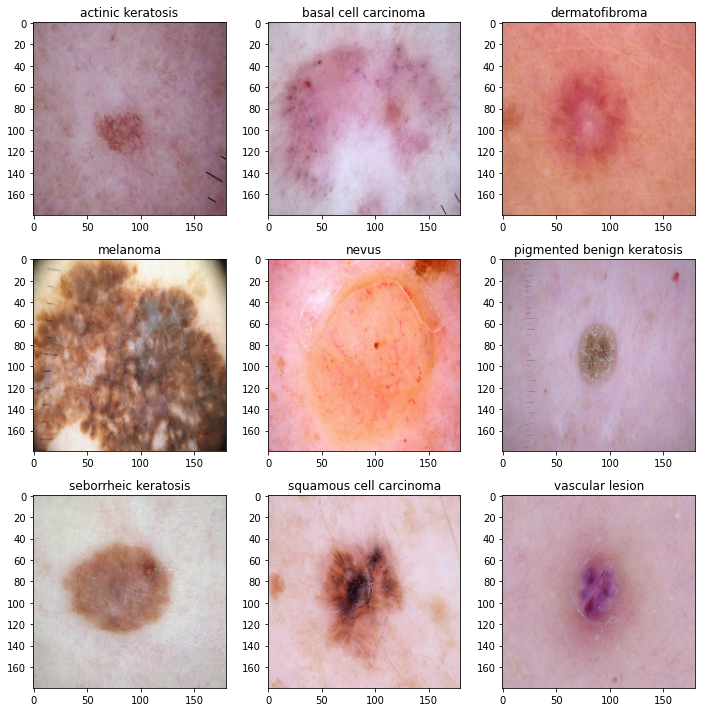

In [14]:
import matplotlib.pyplot as plt
class_to_img = {}
search_class = 0
for element in train_ds:
    for count, class_value in enumerate(element[1].numpy()):
        if class_value == search_class:
            class_to_img[search_class] = element[0][count]
            search_class += 1
            if search_class == 9:
                break
    if search_class == 9:
        break

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(9):
    img_data = class_to_img[i]
    plt.subplot(3,3, i+1)
    plt.imshow(np.float32(img_data/255))
    plt.title(classes[i])
    plt.tight_layout()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
model_1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [20]:
epochs = 20
history1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 169s 3s/step - loss: 2.0613 - accuracy: 0.2017 - val_loss: 2.0232 - val_accuracy: 0.1863
Epoch 2/20
57/57 [==============================] - 76s 1s/step - loss: 2.0376 - accuracy: 0.1806 - val_loss: 2.0150 - val_accuracy: 0.1996
Epoch 3/20
57/57 [==============================] - 76s 1s/step - loss: 1.9713 - accuracy: 0.2476 - val_loss: 1.9421 - val_accuracy: 0.2616
Epoch 4/20
57/57 [==============================] - 76s 1s/step - loss: 1.7611 - accuracy: 0.3363 - val_loss: 1.7093 - val_accuracy: 0.3370
Epoch 5/20
57/57 [==============================] - 75s 1s/step - loss: 1.6973 - accuracy: 0.3806 - val_loss: 1.6869 - val_accuracy: 0.3548
Epoch 6/20
57/57 [==============================] - 75s 1s/step - loss: 1.6185 - accuracy: 0.4089 - val_loss: 1.6558 - val_accuracy: 0.3880
Epoch 7/20
57/57 [==============================] - 75s 1s/step - loss: 1.5794 - accuracy: 0.4371 - val_loss: 1.6545 - val_accuracy: 0.3880
Epoch 8/20
57/57 [=

### Visualizing training results

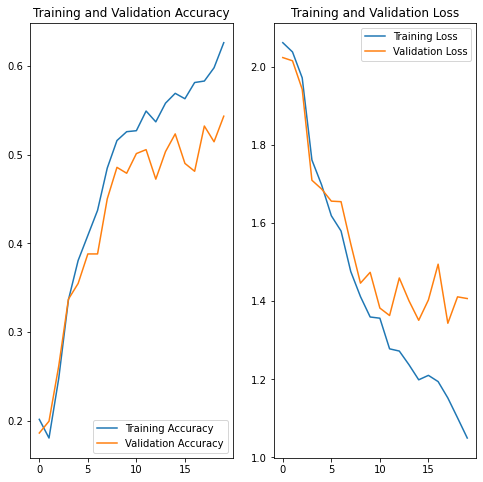

In [21]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
-The training accuracy has a constant rise upto 0.64, while the validation accuracy fluctuates between 0.45 and 0.55. 

This seems to be a Underfit model, as the accuracy is low(i.e. close to 0.5~)

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3), seed=123),
    layers.experimental.preprocessing.RandomRotation(0.1, seed=123),
    layers.experimental.preprocessing.RandomZoom(0.1,0.1, seed=123),
  ]
)

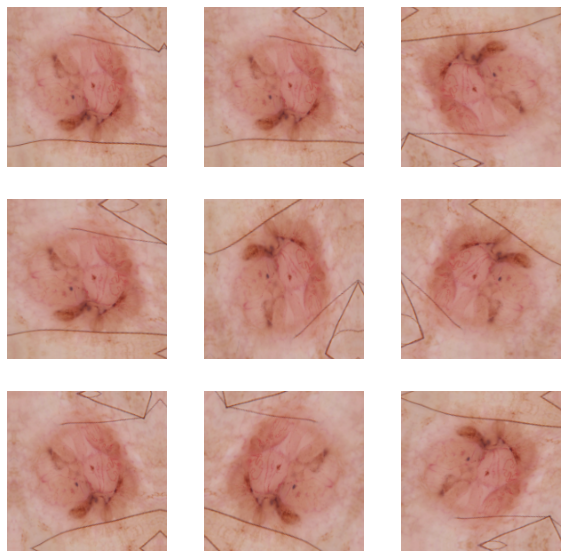

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
model_2 = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
layers.Conv2D(32, (3,3), activation='relu', padding='same'), 
layers.Conv2D(32, (3,3), activation='relu'),
#BatchNormalization(),
layers.MaxPooling2D(pool_size=(2,2)),
layers.Dropout(0.7),

layers.Conv2D(64, (3,3), activation='relu', padding='same'),
layers.Conv2D(64, (3,3), activation='relu'),
#BatchNormalization(),
layers.MaxPooling2D(pool_size=(2,2)),
layers.Dropout(0.7),

layers.Conv2D(128, (3,3), activation='relu', padding='same'), 
layers.Conv2D(128, (3,3), activation='relu'),
#BatchNormalization(), 
layers.MaxPooling2D(pool_size=(2,2)),
layers.Dropout(0.7),

layers.Flatten(),
layers.Dense(100, activation='relu'),
layers.Dropout(0.7), 
layers.Dense(9, activation='softmax')
])

### Compiling the model

In [25]:
## Your code goes here
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 87, 64)       

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs= 20
history2 = model_2.fit(train_ds, validation_data=val_ds, epochs=epochs)## your training code

Epoch 1/20
57/57 [==============================] - 354s 6s/step - loss: 2.2610 - accuracy: 0.1747 - val_loss: 2.0792 - val_accuracy: 0.1863
Epoch 2/20
57/57 [==============================] - 353s 6s/step - loss: 2.0760 - accuracy: 0.1802 - val_loss: 2.0622 - val_accuracy: 0.1863
Epoch 3/20
57/57 [==============================] - 352s 6s/step - loss: 2.0618 - accuracy: 0.2101 - val_loss: 2.0333 - val_accuracy: 0.1996
Epoch 4/20
57/57 [==============================] - 352s 6s/step - loss: 2.0484 - accuracy: 0.1727 - val_loss: 2.0224 - val_accuracy: 0.1863
Epoch 5/20
57/57 [==============================] - 352s 6s/step - loss: 2.0593 - accuracy: 0.1673 - val_loss: 2.0233 - val_accuracy: 0.1996
Epoch 6/20
57/57 [==============================] - 352s 6s/step - loss: 2.0619 - accuracy: 0.1799 - val_loss: 2.0266 - val_accuracy: 0.1996
Epoch 7/20
57/57 [==============================] - 352s 6s/step - loss: 2.0405 - accuracy: 0.2046 - val_loss: 2.0275 - val_accuracy: 0.1996
Epoch 8/20
57

### Visualizing the results

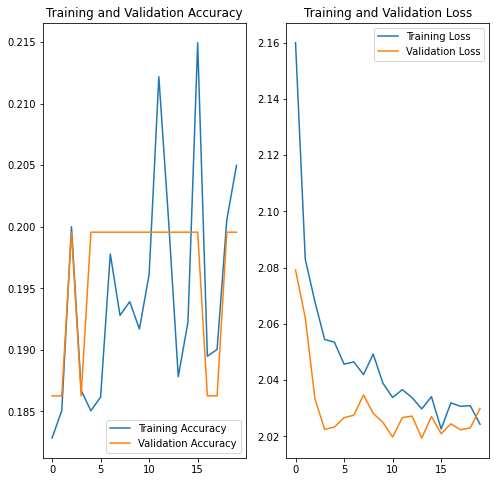

In [28]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Write your findings here:** The above model has shown a training accuracy of 0.3211 and a validation accuracy of 0.1924. This model shows a clear case of class imbalances and overfitting.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
## Your code goes here.
path_to_dataset = "gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/"
path_to_training_dataset = path_to_dataset + "Train"
path_to_test_dataset = path_to_dataset + "Test"

data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_test_dataset)

In [30]:
class_counts = [len(list(data_dir_train.glob(class_name + '/*.jpg'))) for class_name in classes]
class_counts_df = pd.DataFrame({"class": classes, "count": class_counts})
class_counts_df['proportion'] = round(class_counts_df['count']/class_counts_df['count'].sum(),2)
class_counts_df

,class,count,proportion
0,actinic keratosis,0,NaN
1,basal cell carcinoma,0,NaN
2,dermatofibroma,0,NaN
3,melanoma,0,NaN
4,nevus,0,NaN
5,pigmented benign keratosis,0,NaN
6,seborrheic keratosis,0,NaN
7,squamous cell carcinoma,0,NaN
8,vascular lesion,0,NaN


Text(0.5, 1.0, 'Cancer dataset class distributions')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

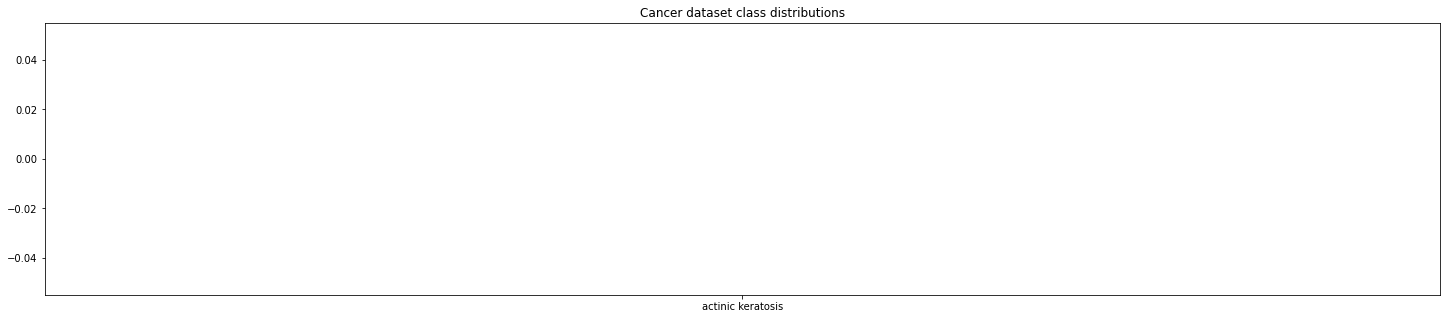

In [31]:
plt.figure(figsize=(25,5))
plt.bar(class_counts_df['class'], class_counts_df['proportion'])
for index, value in enumerate(class_counts_df['proportion']):
    plt.text(index - 0.05, value + 0.001, str(value))
plt.title("Cancer dataset class distributions")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
# creating path for training dataset
path_to_dataset = "gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/"
path_to_training_dataset = path_to_dataset + "Train"
path_to_test_dataset = path_to_dataset + "Test"

data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_test_dataset)

In [39]:
path_list_orig = [x for x in list(data_dir_train.glob('*/*.jpg'))]
path_list_orig[:5]

[PosixPath('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/ISIC_0025811.jpg'),
 PosixPath('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/ISIC_0026720.jpg'),
 PosixPath('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/ISIC_0025182.jpg'),
 PosixPath('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/ISIC_0025089.jpg'),
 PosixPath('gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/ISIC_0026100.jpg')]

In [40]:
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in list(data_dir_train.glob('*/*.jpg'))]
lesion_list_orig[:5]

['Train', 'Train', 'Train', 'Train', 'Train']

In [41]:
dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))

In [42]:
original_df= pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])

In [43]:
original_df.head()

,Path,Label
0,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
1,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
2,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
3,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
4,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train


In [44]:
original_df['Label'].value_counts()

Train    2256
Name: Label, dtype: int64

In [45]:
import Augmentor
for i in classes:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F83FFDD1A10>: 100%|██████████| 500/500 [00:22<00:00, 21.85 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 378 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F83FFD131D0>: 100%|██████████| 500/500 [00:26<00:00, 18.70 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8403636A90>:   0%|          | 2/500 [00:00<01:23,  5.95 Samples/s]                  

Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8403964150>: 100%|██████████| 500/500 [00:22<00:00, 22.22 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F83FFCECD10>: 100%|██████████| 500/500 [01:40<00:00,  4.98 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 362 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F83FFDA5510>: 100%|██████████| 500/500 [01:38<00:00,  5.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 463 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84138BBE10>: 100%|██████████| 500/500 [00:22<00:00, 22.47 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F83FFE0C210>: 100%|██████████| 500/500 [00:49<00:00, 10.13 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 190 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84036178D0>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8403617090>: 100%|██████████| 500/500 [00:23<00:00, 21.64 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [47]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031852.jpg_c41f6316-4b4c-4dc6-9198-75c75e84c86b.jpg',
 'gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025712.jpg_26a4c71b-e216-4c72-a78e-1c00993bcab3.jpg',
 'gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025471.jpg_1933fba2-7fd8-418f-a34f-796a663f209c.jpg',
 'gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031043.jpg_4e89d226-c6ad-416f-b4bf-2168f2028d5f.jpg',
 'gdrive/MyDrive/DataSets/SkinCancerISICTheInternationalSkinImagingCollaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_

In [48]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
np.unique(lesion_list_new)

array(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion'], dtype='<U26')

In [49]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [51]:
new_df.head()

,Path,Label
0,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
1,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
2,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
3,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train
4,gdrive/MyDrive/DataSets/SkinCancerISICTheInter...,Train


In [52]:
new_df['Label'].value_counts()

Train                         2256
melanoma                       500
basal cell carcinoma           500
nevus                          500
dermatofibroma                 500
squamous cell carcinoma        500
actinic keratosis              500
vascular lesion                500
seborrheic keratosis           500
pigmented benign keratosis     500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6756 files belonging to 9 classes.
Using 5405 files for training.


#### **Todo:** Create a validation dataset

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6756 files belonging to 9 classes.
Using 1351 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [56]:
## your code goes here
model_3 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(32, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [57]:
## your code goes here
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [58]:
epochs = 30
history =model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) # your model fit code

Epoch 1/30
169/169 [==============================] - 299s 2s/step - loss: 2.1308 - accuracy: 0.1461 - val_loss: 1.7794 - val_accuracy: 0.3412
Epoch 2/30
169/169 [==============================] - 294s 2s/step - loss: 1.7151 - accuracy: 0.3168 - val_loss: 1.5287 - val_accuracy: 0.4101
Epoch 3/30
169/169 [==============================] - 295s 2s/step - loss: 1.5154 - accuracy: 0.4004 - val_loss: 1.3511 - val_accuracy: 0.4789
Epoch 4/30
169/169 [==============================] - 295s 2s/step - loss: 1.4268 - accuracy: 0.4391 - val_loss: 1.4106 - val_accuracy: 0.4611
Epoch 5/30
169/169 [==============================] - 296s 2s/step - loss: 1.3706 - accuracy: 0.4551 - val_loss: 1.3939 - val_accuracy: 0.4804
Epoch 6/30
169/169 [==============================] - 299s 2s/step - loss: 1.3164 - accuracy: 0.4801 - val_loss: 1.2852 - val_accuracy: 0.5011
Epoch 7/30
169/169 [==============================] - 297s 2s/step - loss: 1.2588 - accuracy: 0.5123 - val_loss: 1.1865 - val_accuracy: 0.5418

#### **Todo:**  Visualize the model results

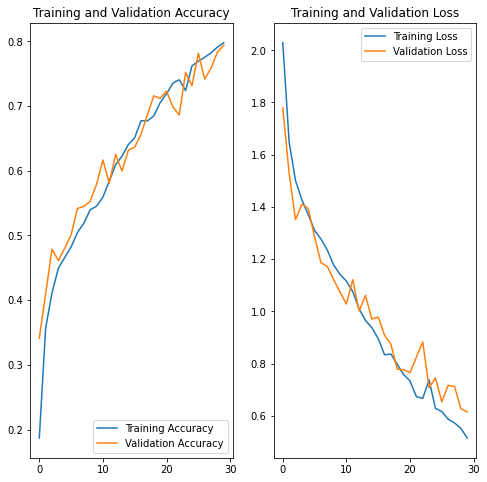

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
model_3.evaluate(test_ds)

4/4 [==============================] - 37s 519ms/step - loss: 3.2528 - accuracy: 0.4492


[3.2528278827667236, 0.44915252923965454]

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

On training the 3rd model, after Augmentation, we were able to get rid of the major Underfit/Overfit that we were facing with the previous models.
We were able to achieve a Training Accuracy of **78.93%** and Validation accuracy of **79.42%**
Training loss:**0.5345** and Validation loss:**0.6146**